# `Part 1/3: Candle data collection with Binance API`

The purpose of this series of notebooks is to showcase real-time candle, trade and order book data collection methods from Binance exchange.

Data is collected through websockets and then stored in SQL databases.

Possible applications of the stored data include:
* creation of custom alerts for discretionary trading 
* development of a fully automated systematic training system based on a set of predetermined rules

#### Author: Vladislav Semin

## 1. Import libraries

In [1]:
import time
import calendar
from datetime import datetime

import pandas as pd #to create a dataframe

import websocket
from binance.client import Client # Import the Binance Client
from binance.websockets import BinanceSocketManager # Import the Binance Socket Manager

import sqlalchemy as db
from sqlalchemy import create_engine

## 2. Setup Binance websocket connection

**IMPORTANT NOTE:** 
This kernel will not run without API keys. Register an account at Binance crypto exchange website to get your API keys:
* https://www.binance.com/en/register

In [2]:
# Input Binance API keys
# PUBLIC = ''
# SECRET = ''

In [3]:
# Setup Binance websocket connection
client = Client(api_key=PUBLIC, api_secret=SECRET)
bm = BinanceSocketManager(client)

## 3. Select cryptocurrency pair

In [4]:
# We will be collecting data for the following cryptocurrency pair
pair = 'ETHBTC'

## 4. Setup SQL database

In [5]:
# Select name for SQL database
k_lines_db = 'binance_k_lines_{}'.format(pair)

In [6]:
# Set up engine to append the values to the SQL database
engine = create_engine('sqlite:///{}.db'.format(k_lines_db), echo=False)

## 5. Set up data collection format

#### K-lines (candles) are useful for % change alerts within a particular timeframe
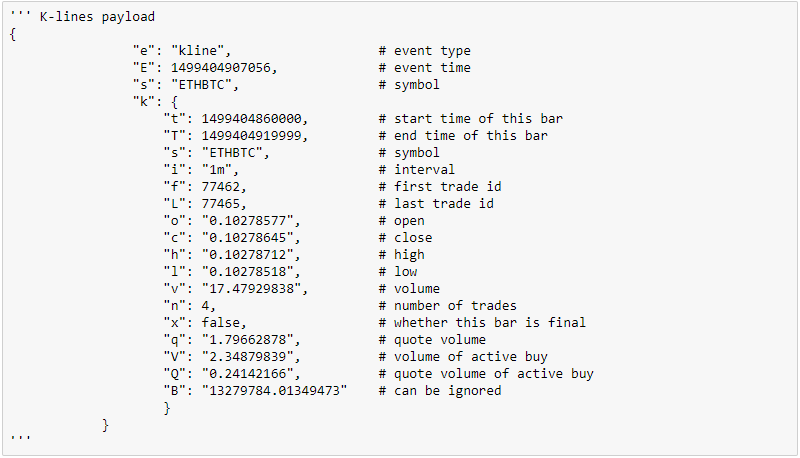

In [7]:
# k_line_message is a callback function requested by .start_kline_socket method of BinanceSocketManager class
def k_line_message(msg):

    global engine
    global k_lines_db 
    
    if msg['e'] == 'error':    
        print(msg['m'])
        
    else:
        # Timestamp converted to date time with microseconds
        time_ = msg['E'] / 1000
        time_ = datetime.fromtimestamp(time_).strftime("%Y-%m-%d %H:%M:%S.%f") 
            
        # Streaming candles data
        kline_stream_dict = {'Event Time': time_,'Event t-stamp': msg['E'], 
                             'Bar start t-stamp': msg['k']['t'], 'Bar end t-stamp': msg['k']['T'], 
                             'Pair': msg['s'], 'Interval': msg['k']['i'],
                             'Vol': msg['k']['v'], 'Vol of active buy': msg['k']['V'], 
                             'Quote vol': msg['k']['q'], 'Quote vol of active buy': msg['k']['Q'], 
                             'Number of trades': msg['k']['n'],
                             'Open': msg['k']['o'], 'Close': msg['k']['c'], 'High': msg['k']['h'], 'Low': msg['k']['l'], 
                             'First trade ID': msg['k']['f'], 'Last trade ID': msg['k']['L'], 
                             'Final bar': msg['k']['x'], 'Ignore': msg['k']['B'], 'Event': msg['e']}
                             
        
        kline_stream_df = pd.DataFrame([kline_stream_dict]).set_index('Event Time')  
        
        # real-time export of streaming dataframes to SQLite database        
        kline_stream_df.to_sql(k_lines_db,if_exists="append", con=engine)
        
        # Event message acknowledging new trades occurring on the exchange
        print('### {} candle data updated at {}'.format(msg['s'], time_))

## 6. Collect candle data

In [8]:
conn_key_k_line = bm.start_kline_socket(pair, k_line_message, interval=Client.KLINE_INTERVAL_1MINUTE)

bm.start()

# For testing purposes, streaming period is set to 15 seconds. Max connection time is 24 hrs.
time.sleep(15) 

bm.stop_socket(conn_key_k_line)

bm.close()

### ETHBTC candle data updated at 2020-04-23 01:39:07.519000
### ETHBTC candle data updated at 2020-04-23 01:39:09.909000
### ETHBTC candle data updated at 2020-04-23 01:39:12.093000


## 7. Check the data appended to SQL database

In [9]:
# Select and show data from the dataframe
binance_candles = engine.execute("SELECT * FROM " + k_lines_db).fetchall()

# We can see raw SQL data here: 
binance_candles

[('2020-04-23 01:39:07.519000', 1587595147519, 1587595080000, 1587595139999, 'ETHBTC', '1m', '15.62000000', '3.02600000', '0.39975449', '0.07745574', 22, '0.02559600', '0.02559100', '0.02559700', '0.02559100', 173057918, 173057939, 1, '0', 'kline'),
 ('2020-04-23 01:39:09.909000', 1587595149909, 1587595140000, 1587595199999, 'ETHBTC', '1m', '0.00000000', '0.00000000', '0.00000000', '0.00000000', 0, '0.02559100', '0.02559100', '0.02559100', '0.02559100', -1, -1, 0, '0', 'kline'),
 ('2020-04-23 01:39:12.093000', 1587595152093, 1587595140000, 1587595199999, 'ETHBTC', '1m', '0.19200000', '0.19200000', '0.00491462', '0.00491462', 1, '0.02559700', '0.02559700', '0.02559700', '0.02559700', 173057940, 173057940, 0, '0', 'kline')]

In [10]:
# Or we can transform SQL data into pandas dataframe
df = pd.DataFrame(binance_candles, columns=["Event Time", 'Event t-stamp', 
                                            'Bar start t-stamp', 'Bar end t-stamp', 
                                            'Pair', 'Interval', 
                                            'Vol', 'Vol of active buy', 
                                            'Quote vol', 'Quote vol of active buy',
                                            'Number of trades',
                                            'Open', 'Close', 'High', 'Low', 
                                            'First trade ID', 'Last trade ID', 
                                            'Final bar', 'Ignore', 'Event']).set_index('Event Time')

df.head()

,Event t-stamp,Bar start t-stamp,Bar end t-stamp,Pair,Interval,Vol,Vol of active buy,Quote vol,Quote vol of active buy,Number of trades,Open,Close,High,Low,First trade ID,Last trade ID,Final bar,Ignore,Event
Event Time,,,,,,,,,,,,,,,,,,,
2020-04-23 01:39:07.519000,1587595147519,1587595080000,1587595139999,ETHBTC,1m,15.62000000,3.02600000,0.39975449,0.07745574,22,0.02559600,0.02559100,0.02559700,0.02559100,173057918,173057939,1,0,kline
2020-04-23 01:39:09.909000,1587595149909,1587595140000,1587595199999,ETHBTC,1m,0.00000000,0.00000000,0.00000000,0.00000000,0,0.02559100,0.02559100,0.02559100,0.02559100,-1,-1,0,0,kline
2020-04-23 01:39:12.093000,1587595152093,1587595140000,1587595199999,ETHBTC,1m,0.19200000,0.19200000,0.00491462,0.00491462,1,0.02559700,0.02559700,0.02559700,0.02559700,173057940,173057940,0,0,kline


## References:
#### Binance API Python libraries used in this demonstration:

https://gist.github.com/alexbrillant/961502146a7fc5d03205f9b07b8535f5 - Binance Socket Manager class and its methods

https://github.com/binance-exchange/python-binance